# Chapter 5
## Compressing data via dimensionality reduction

Instead of simply choosing a subset of features to reduce dimensionality, *feature extraction* can also be used. This is when data is projected onto a new feature space, without loosing data information.  This not only improves resource use, but can also prevent the curse of dimensionality.  This becomes important when using non-regularized models.

## Main steps in Principle Component Analysis

*Principle component analysis* (PCA) tries to find directions of maximum variance in high dimensional datasets, then projects the data onto a space with fewer dimensions.  

A transformation matrix, $W = d \times k$, that transforms a training record $x$ onto a $k$-dimensional feature space.  If:
$$
    x = [x_1, \dots, x_d] \in \mathbb{R}^d
$$
Then apply $W$ to $x$:
$$
    xW = z
$$
such that
$$
    z = [z_1, \dots, z_k] \in \mathbb{R}^k
$$
where $k<d$, typically $k \ll d$.

The algorithm can be summarized in the following steps:
1. Standardize the $d$-dimensional feature space
2. Construct the covariance matrix, $\Sigma$
3. Decompose $\Sigma$ into eigenvectors and eigenvalues
4. Sort eigenvalues in decreasing order to rank the corresponding eigenvectors
5. Select $k$ eigenvectors based on their eigenvalues; $k$ is the dimensionality of the new feature space  
6. Construct the transformation matrix, $W$, from the $k$ eigenvectors
7. Transform the dataset, $X$, via $W$

More information:
- [Eigenvectors](https://mathworld.wolfram.com/Eigenvector.html)
    - recall that the characteristic polynomial must have zero roots, in this case they should be real valued, not complex valued.
    - also note that $\text{det} (A- \lambda I) = 0$, which leads to a reduction in dimensions
- [Determinant](https://en.wikipedia.org/wiki/Determinant)
    - note: "... the determinant is nonzero if and only if the matrix is invertible and the linear map represented by the matrix is an isomorphism."
- [Eigen decomposition](https://mathworld.wolfram.com/EigenDecomposition.html)

## Extracting principle components step by step
1. data is split and standardized

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
df_wine = pd.read_csv('wine_data.csv').drop(columns = ['Unnamed: 0'])
#use a .7/.3 split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

2. compute the covariance matrix

The covariance matrix, $\Sigma$, is the matrix that stores the pairwise covariances between features:
$$
    \sigma_jk = \frac{1}{n-1} \sum_{i=1}^n (x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)
$$

The eigenvectors of $\Sigma$ will be the principle components of teh maximum variance

In [2]:
cov_mat = np.cov(X_train_std.T)

3. compute the eigenvalues and eigenvectors
Recall the definition of eigenvectors:
$$
    \Sigma v = \lambda v
$$
where $v$ is the eigenvector and $\lambda$ is the eigenvalue.

(Note that the characteristic polynomial might have complex roots, but numpy has the `numpy.linalg.eigh` method which will use Hermetian matrices; these will be real valued eigenvectors).

In [3]:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

### Total and explained variance

To map to a lower dimension feature space, only the eigenvectors with the highest variance are selected. This is determined by the explained variance ratio
$$
    \frac{\lambda_j}{\sum_{j=1}^d \lambda_j}
$$

This is calculated using the cumulative sum function in numpy, `cumsum`.  Note that the first two components account for almost 0.6 of the variance.

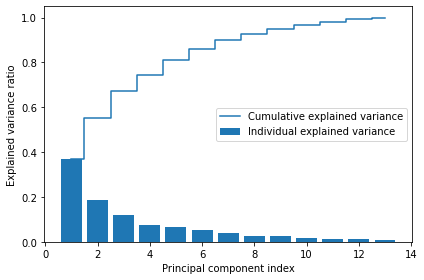

In [4]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, align='center', label='Individual explained variance') 
plt.step(range(1,14), cum_var_exp, where='mid', label='Cumulative explained variance') 
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Feature transformtion

1. Select $k$ eigenvectors, where $k$ is the required dimensions

In [5]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k : k[0], reverse = True)

2. Get the $k$ eigenvectors to make $W$, the transformation matrix.

Note that $W$ is a $13 \times 2$, so the new feature space with be $1 \times 2$; recalling: $xW = z$

In [6]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
w

array([[-0.13724218,  0.50303478],
       [ 0.24724326,  0.16487119],
       [-0.02545159,  0.24456476],
       [ 0.20694508, -0.11352904],
       [-0.15436582,  0.28974518],
       [-0.39376952,  0.05080104],
       [-0.41735106, -0.02287338],
       [ 0.30572896,  0.09048885],
       [-0.30668347,  0.00835233],
       [ 0.07554066,  0.54977581],
       [-0.32613263, -0.20716433],
       [-0.36861022, -0.24902536],
       [-0.29669651,  0.38022942]])

Now apply the trasnformation matrix to obtain $x'$

In [7]:
X_train_std[0].dot(w)

array([2.38299011, 0.45458499])

## Principal component analysis in scikit-learn

`PCA` class in scikit-learn is a transformer. 

In [8]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

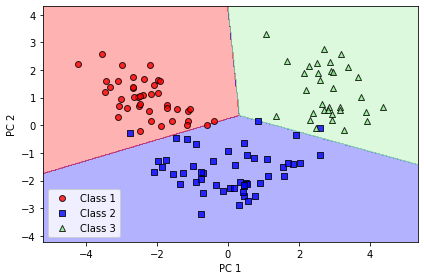

In [9]:
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
lr = LogisticRegression(multi_class = 'ovr', random_state = 1, solver = 'lbfgs')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pcs = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

PCA is also useful for calculating the explained variance by passing `None` for `n_components`.

In [10]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

### Assessing feature contributions

- *loadings* : how much each individual feature contributes to a given principle component.  It is equal to $v\sqrt{\lambda}$, eigenvector scaled by the square root of the eigenvalue.

Note that these are correlations: a value of $1$ is a strong positive correlations and $-1$ is a strong negative correlation.  Features $6$ and $7$ are the strongest negative correlations, and $8$ is strongly positive correlation.

In [11]:
loadings = eigen_vecs * np.sqrt(eigen_vals)
#can also use the scikitlearn object
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

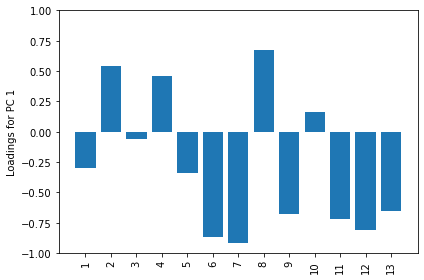

In [12]:
fig, ax = plt.subplots()
ax.bar(range(13), loadings[:, 0], align='center') 
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90) 
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

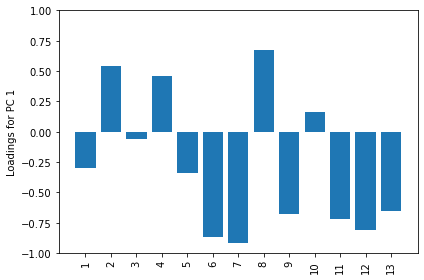

In [13]:
#plot for scikitlearn loadings
fig, ax = plt.subplots()
ax.bar(range(13), sklearn_loadings[:, 0], align='center') 
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(13))
ax.set_xticklabels(df_wine.columns[1:], rotation=90) 
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

## Supervised data compression via linear discriminant analysis
The goal of *linear discriminant analysis* (LDA) is to find feature subspaces that optimize class seperability. Like PCA, it is a linear transformation technique; therefore, it finds a transformtion matrix, $W$, such that $xW=z$ where $z$ is in a feature subspace. LDA assumes:
- Data is normally distributed
- Classes have identical covariance matrices
- Training samples are independent of each other
However, LDA can work reasonably well when these are violated slightly.

### LDA workings

1. standardize $d$ dimensional dataset
2. for each class compute the $d$ dimensional mean vector
3. construct a between-class scatter matrix, $S_B$, and a within class scatter matrix, $S_W$.
4. computer eigenvectors and eigenvalues of $S_B^{-1}S_B$
5. sort eigenvalues in decreasing order, and sort their corresponding eigenvectors
6. choose $k$ eigenvectors that correspond to the $k$ largest eigenvalues and use these as the columns of the $W$ transformation matrix
7. use $W$ to project the features onto the new feature subspace

Note that the algorithm is very similar to PCA; however, the mean (in the form of a mean vector for each class and scatter matrices) is used which assumes that there are already existing class groupings.

#### Computing scatter matrices
(example will use the already stadardized `df_wine` dataset)

Computing the scatter matrices first requires the computation of the mean vectors for each of $i$ classes:
$$
    m_i = \frac{1}{n_i} \sum_{x \in D_i} x_m
$$
This makes a mean vector for each class.  The mean vector for the $i$th class, $m_i$, looks like:
$$
    m_i = \left[\begin{matrix} \mu_1 \\ \vdots \\ \mu_k \end{matrix}\right]
$$
where $k$ is the number of features.

In [14]:
mean_vecs = list()
for label in range(1,4):
    mean_vecs.append(
        np.mean(X_train_std[y_train==label], axis = 0) #take the mean along the column (axis = 0)
    )
    print(f'MV {label}: {mean_vecs[label - 1]}\n')

MV 1: [ 0.9065826  -0.34973457  0.32010329 -0.71891449  0.50558678  0.88069702
  0.95894709 -0.55161049  0.54159322  0.23383109  0.58971299  0.65631399
  1.20749382]

MV 2: [-0.87487963 -0.28480003 -0.37347228  0.31571225 -0.38480347 -0.04332505
  0.06345321 -0.09460613  0.07034749 -0.82860474  0.31436962  0.36084258
 -0.72528643]

MV 3: [ 0.199215    0.8660339   0.168163    0.41484489 -0.04511771 -1.02855532
 -1.28756034  0.82867687 -0.77947565  0.96494432 -1.20899133 -1.36215159
 -0.40130076]



Using the mean vectors, we can compute the scatter matrices.  Within class:
$$
    S_W = \sum_{i=1}^c S_i
$$
where we sum the scatter matrix for each class:
$$
    S_i = \sum_{x \in D_i} (x - m_i)(x - m_i)^T 
$$

(Note, we are adding matrices in each sum, so the overall sum is a matrix)

In [15]:
d = 13 #number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print(f'Within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Within-class scatter matrix: 13x13


Note that the labels are not evenly distributed:

In [16]:
print(f'Class label distribution: {np.bincount(y_train)[1:]}')

Class label distribution: [41 50 33]


This is contrary to the assumptions of LDA. Therefore, each $S_i$ needs to be scaled before summing as $S_W$.  In order to scale, we divide by $n_i$, the number of examples in class $i$:
$$
    \frac{1}{n_i} \sum_{x \in D_i} (x - m_i)(x - m_i)^T
$$
Note that this is the covariance matrix for the $i$th class, $\Sigma_i$.

In [17]:
d = 13 # number of features
S_W = np.zeros((d, d))
for label,mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print(f'Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}')

Scaled within-class scatter matrix: 13x13


Now compute the between class scatter matrix:
$$
    S_B = \sum_{i=1}^c n_i(m_i - m)(m_i - m)^T
$$
where $m$ is the overall mean (i.e. includes data from all classes).

In [18]:
mean_overall = np.mean(X_train_std, axis=0) 
mean_overall = mean_overall.reshape(d, 1)
d = 13 # number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1) # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print(f'Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}')

Between-class scatter matrix: 13x13


#### Selecting linear discriminant for the new feature space
- The remaining steps are similar to PCA

Compute the eigenvectors and eigenvalues of $S_W^{-1}S_B$ (Does it matter that some are complex valued?)

In [19]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_vals

array([ 5.68434189e-14+0.00000000e+00j,  1.72761522e+02+0.00000000e+00j,
        3.49617809e+02+0.00000000e+00j, -3.63360049e-14+0.00000000e+00j,
       -1.59197501e-14+2.44271400e-14j, -1.59197501e-14-2.44271400e-14j,
       -1.47445915e-14+0.00000000e+00j, -1.05959798e-14+1.19958279e-14j,
       -1.05959798e-14-1.19958279e-14j,  1.65329587e-14+1.07237868e-15j,
        1.65329587e-14-1.07237868e-15j,  6.27139861e-15+0.00000000e+00j,
       -2.04742590e-15+0.00000000e+00j])

Sort them in descending order:

In [20]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n') 
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:

349.617808905994
172.76152218979394
5.684341886080802e-14
3.63360048868007e-14
2.9156879278165203e-14
2.9156879278165203e-14
1.6567701054331684e-14
1.6567701054331684e-14
1.6005457633433247e-14
1.6005457633433247e-14
1.4744591544911198e-14
6.2713986138368715e-15
2.0474258990949274e-15


At most there will be $c - 1$ linear discriminants, where $c$ is the number of class labels (note: if we can discriminate two of the three class, then whatever is left must be the third class).  Here there are 3 class labels and two non-zero linear discriminats (the other low values are due to floating point arithmetic).

To measure how well they distinguish the classes, we can take the ratio of the real part of the eigenvalue and the sum of all the real parts of the eigenvalues.  This is the *discriminability*; as can be seen, the two eigenvectors reach 1.00 of the data.

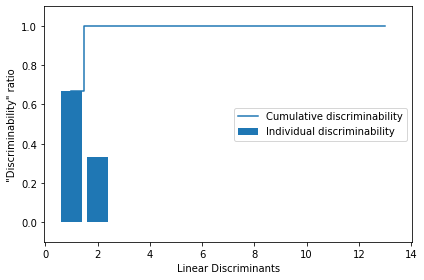

In [21]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)] 
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, align='center', label='Individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative discriminability') 
plt.ylabel('"Discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1]) 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

Make $W$, the transformation matrix, by stacking the two eigenvectors next to each other.

In [22]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real)) 
print('Matrix W:\n', w)

Matrix W:
 [[-0.14808266 -0.40918668]
 [ 0.09076942 -0.15765978]
 [-0.01678204 -0.35371242]
 [ 0.14840098  0.32231568]
 [-0.0163456  -0.08168973]
 [ 0.19130756  0.08419165]
 [-0.73377547  0.28234956]
 [-0.07501992 -0.01015645]
 [ 0.00184929  0.09065024]
 [ 0.29402743 -0.2152308 ]
 [-0.03282632  0.27470975]
 [-0.35466909 -0.01243875]
 [-0.39151562 -0.59578685]]


#### Using $W$ to project into the new feature space
Use:
$$
    X' = XW
$$

It become clear that the classes are now linearly seperable.

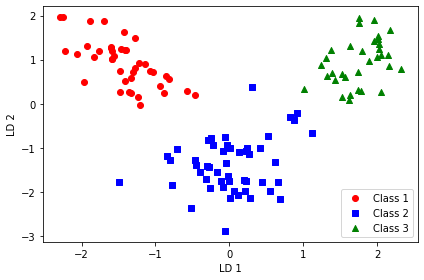

In [23]:
X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
        X_train_lda[y_train==l, 1] * (-1),
        c=c, label= f'Class {l}', marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right') 
plt.tight_layout()
plt.show()


### LDA in scikit-learn



In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

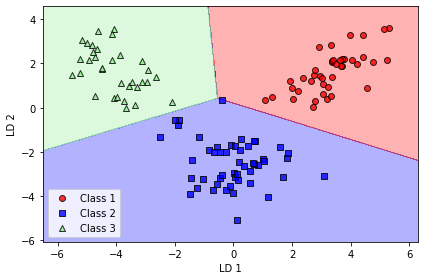

In [27]:
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr) 
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left') 
plt.tight_layout()
plt.show()

Lowering regularization might reclassify the one example that is classified wrong.  However, consider the test set which is all correctly classified:

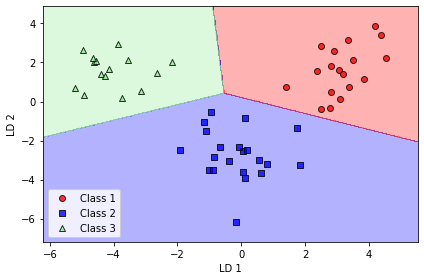

In [28]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr) 
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Nonlinear dimensionality reduction and visualization

#### Why consider nonlinear dimensionality reduction
Many of the ML algorithms assume linear seperability; however, data often is not linearly seperable. Nonlinear reduction techniques are implemented in scikit-learn.  Nonlinear dimensionality reduction are also called *manifold learning* because a *manifold* is a lower dimensional space contained within a higher dimensionsional space.

[Manifolds](https://en.wikipedia.org/wiki/Manifold) - "an n-dimensional manifold, or n-manifold for short, is a topological space with the property that each point has a neighborhood that is homeomorphic to an open subset of n-dimensional Euclidean space."

Note that manifold learning is hard to use, with uncertain results. This is due to multi-dimensional data being hard to understand topologically. 

### t-SNE 
- t-SNE : *t-distributed stochastic neighbor embedding*

t-SNE models pair-wise points based on their distance in the original (higher dimensional) feature space, and finds a similar distribution of distances in the lower dimensional space to the distribution in the higher dimensional space.  Note that t-SNE is unsupervised, and the `y_digits` set is only used for visualization.

To illustrate with scikit-learn, use the digits dataset; this dataset contains images of handwritten digits in 8 px by 8 px images.

In [29]:
from sklearn.datasets import load_digits 
digits = load_digits()

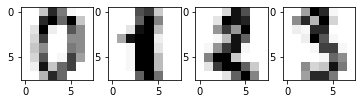

In [32]:
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(digits.images[i], cmap='Greys') 
plt.show()

Access a tabular version of this dataset where images are represented by rows and columns are pixels:

In [34]:
digits.data.shape

(1797, 64)

In [35]:
y_digits = digits.target #the label of the number
X_digits = digits.data #the pixels

Now apply t-SNE via scikit-learn

In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [42]:
X_digits_tsne.shape #the data is now two dimensional

(1797, 2)

Note that `init='pca'` initializes the algorithm with PCA. Note that there are other hyperparameters such as *perplexity* and *learning rate*.

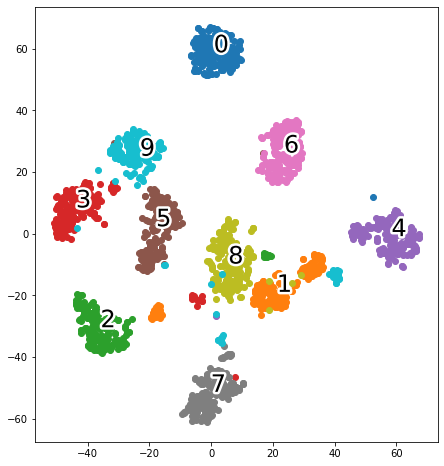

In [43]:
import matplotlib.patheffects as PathEffects 
def plot_projection(x, colors):
    f = plt.figure(figsize=(8, 8)) 
    ax = plt.subplot(aspect='equal') 
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                x[colors == i, 1])
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0) 
        txt = ax.text(xtext, ytext, str(i), fontsize=24) 
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        
plot_projection(X_digits_tsne, y_digits)
plt.show()